In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q /content/drive/MyDrive/plantvillage_dataset.zip -d /content/PlantVillage

In [6]:
!ls /content/PlantVillage/plantvillage/PlantVillage

Pepper__bell___Bacterial_spot  Tomato_Late_blight
Pepper__bell___healthy	       Tomato_Leaf_Mold
Potato___Early_blight	       Tomato_Septoria_leaf_spot
Potato___healthy	       Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Late_blight	       Tomato__Target_Spot
Tomato_Bacterial_spot	       Tomato__Tomato_mosaic_virus
Tomato_Early_blight	       Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

dataset_dir = "/content/PlantVillage/plantvillage/PlantVillage"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")


Total images: 20638
Training images: 16510
Validation images: 4128


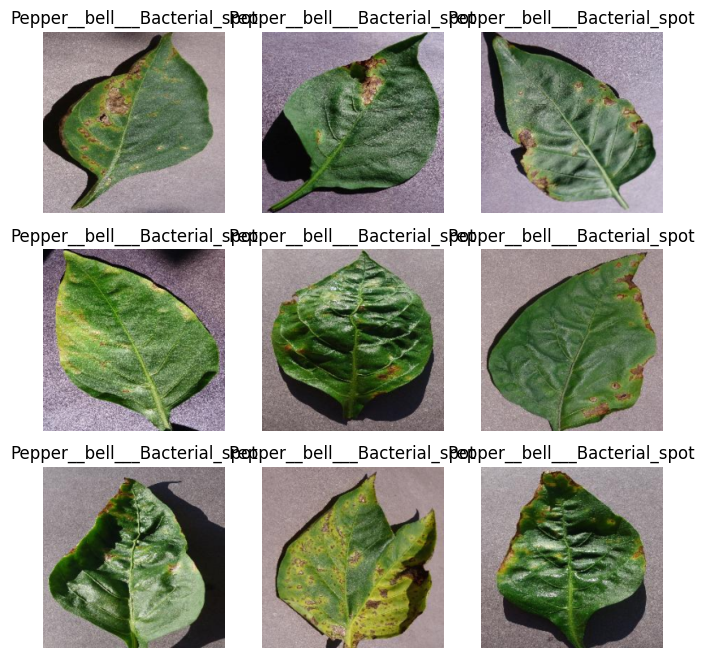

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    img, label = dataset[i]
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(dataset.classes[label])
    ax.axis('off')
plt.show()

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

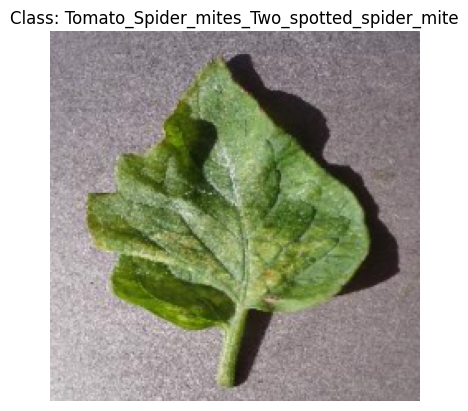

In [12]:
images, labels = next(iter(train_loader))

plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.title(f"Class: {dataset.classes[labels[0]]}")
plt.axis('off')
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlantDiseaseCNN(nn.Module):
    def __init__(self):
        super(PlantDiseaseCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/5] Loss: 1.2003, Val Acc: 80.26%
Epoch [2/5] Loss: 0.4845, Val Acc: 87.21%
Epoch [3/5] Loss: 0.2977, Val Acc: 87.77%
Epoch [4/5] Loss: 0.1927, Val Acc: 87.81%
Epoch [5/5] Loss: 0.1276, Val Acc: 87.98%


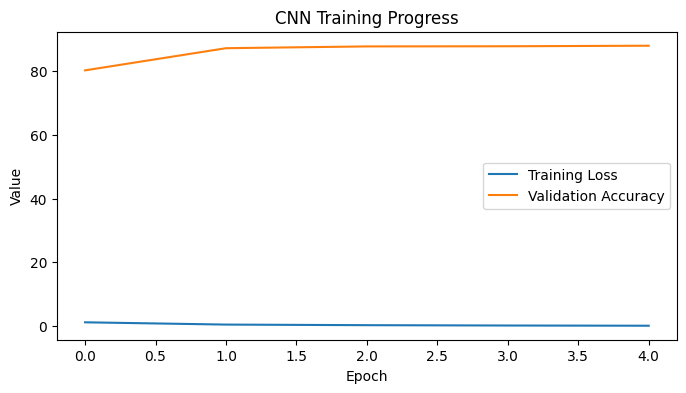

In [15]:
model = PlantDiseaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_accuracies = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {train_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('CNN Training Progress')
plt.legend()
plt.show()

torch.save(model.state_dict(), "plant_disease_cnn.pth")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


Epoch [1/5] | Loss: 0.8113 | Val Acc: 90.24%
Epoch [2/5] | Loss: 0.3668 | Val Acc: 91.21%
Epoch [3/5] | Loss: 0.2910 | Val Acc: 91.84%
Epoch [4/5] | Loss: 0.2552 | Val Acc: 92.64%
Epoch [5/5] | Loss: 0.2322 | Val Acc: 92.85%


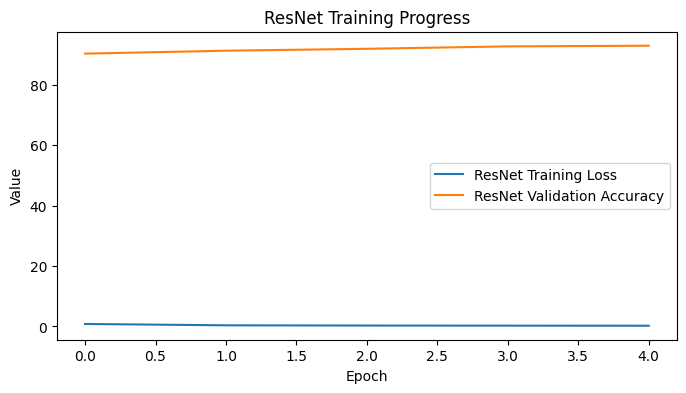

In [17]:
from torchvision import models
import torch.optim as optim

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in resnet.parameters():
    param.requires_grad = False

num_classes = len(dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

train_losses_resnet = []
val_accuracies_resnet = []
num_epochs = 5

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses_resnet.append(running_loss / len(train_loader))

    resnet.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies_resnet.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_losses_resnet[-1]:.4f} | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(8,4))
plt.plot(train_losses_resnet, label='ResNet Training Loss')
plt.plot(val_accuracies_resnet, label='ResNet Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('ResNet Training Progress')
plt.legend()
plt.show()

torch.save(resnet.state_dict(), "plant_disease_resnet.pth")

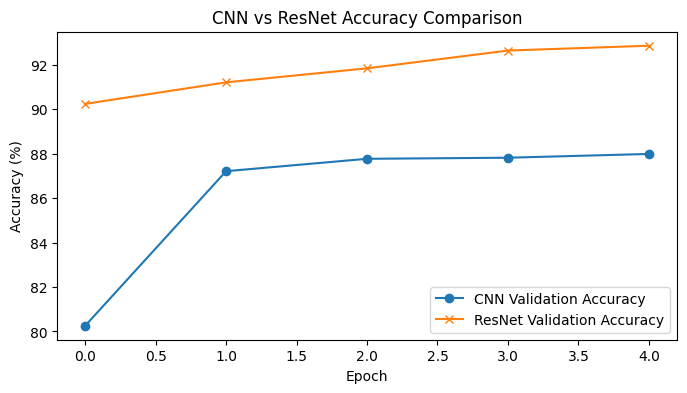

In [18]:
plt.figure(figsize=(8,4))
plt.plot(val_accuracies, label='CNN Validation Accuracy', marker='o')
plt.plot(val_accuracies_resnet, label='ResNet Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CNN vs ResNet Accuracy Comparison')
plt.legend()
plt.show()

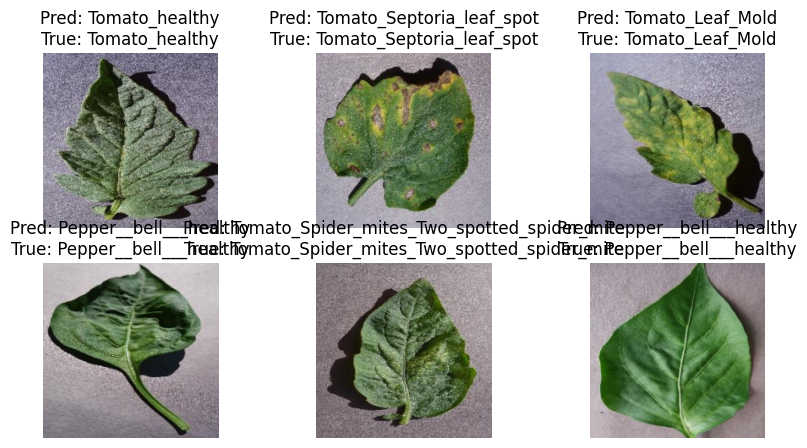

In [19]:
resnet.eval()
images, labels = next(iter(val_loader))
images = images.to(device)
outputs = resnet(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1,2,0)))
    plt.title(f"Pred: {dataset.classes[predicted[i]]}\nTrue: {dataset.classes[labels[i]]}")
    plt.axis('off')
plt.show()